# Experiment 1 -- Distortion

This is a formal experiment on testing the performance of FastMap when approximate the target distance on directed graph.

**Test DataSet:**

1. Simulated random directed graphs (10 random, and get average)
2. State lattice of game map
3. Roadmap, directed

The embedding dimention $K$ is a hyperparameter, and incurs a hiden process of finding the relation between distortion and $K$, and choose the best one for external comparison with other benchmark algorithms.

**Test design:**

1. Test the distortion of embedding `average`
2. Test the distortion of embedding `max`
3. Test the distortion of `min` through embedding `average` and `max`
4. Test the distortion of purely using of differential heuristic
5. Test the distortion of real distances through embedding `average` and `max`, plus the stored true distances.

**Test Goal:**

The accuracy of heuristic value by FastMap.

In [4]:
# Add libraries
%load_ext autoreload
%autoreload 2
import os, sys
lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

import heuristic.fastmap.utils as utils
from heuristic.fastmap.difastmap import init_dis_store, difastmap_average, difastmap_diff, difastmap_max 
import heuristic.fastmap.analyse as analyse

import matplotlib.pyplot as plt
import networkx as nx
import random
import multiprocessing as mp
import numpy as np
import math
from random import sample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Density: 0.007055055055055055


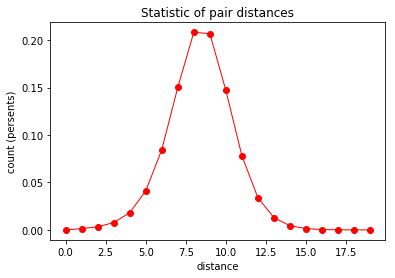

In [3]:
n = 1000
p = 0.007
low = 1
high = 5

G, density = utils.generate_random_digraph(n, p, low, high)
utils.distance_info(G)

In [3]:

def meta_distortion(i):
    global G, embedding, subset, alg, variant
    node_1=subset[i]
    emb_1 = np.array(embedding[node_1])
    length = nx.single_source_dijkstra_path_length(G, node_1)
    sigma = 0
    ave_d = 0
    for j in range(i+1, len(subset)):
        node_2 = subset[j]
        emb_2 = np.array(embedding[node_2])
        distance = length[node_2]
        if variant == 'undirected':
            target_dis = distance
        elif variant == 'average':
            distance_reverse = nx.dijkstra_path_length(G, node_2, node_1)
            target_dis = (float(distance) + float(distance_reverse))/2
        elif variant == 'max':
            distance_reverse = nx.dijkstra_path_length(G, node_2, node_1)
            target_dis = max(float(distance), float(distance_reverse))
        elif variant == 'diff':
            distance_reverse = nx.dijkstra_path_length(G, node_2, node_1)
            target_dis = abs(float(distance) - float(distance_reverse))/2
        if alg == 'L1':
            embdis = np.sum(np.abs(emb_1-emb_2))
        elif alg == 'L2':
            embdis = math.sqrt(np.dot(emb_1-emb_2, emb_1-emb_2))
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d]

def distortion_mp(G, embedding, subset, alg, variant):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)/2
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

## Test the distortion of embedding average

In [4]:
n = 1000
p = 0.007
low = 1
high = 2

G, density = utils.generate_random_digraph(n, p, low, high)
klist = [19, 20, 21, 22, 23, 24, 25]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_mp(G, embedding, subset, alg, variant)
    print(results)

Density: 0.0069019019019019015
#########Test for K:19
Pool size: 8
0.2202064340887044
#########Test for K:20
Pool size: 8
0.20749105403158655
#########Test for K:21
Pool size: 8
0.19642854480789146
#########Test for K:22
Pool size: 8
0.2129305606489461
#########Test for K:23
Pool size: 8
0.20341642589268447
#########Test for K:24
Pool size: 8
0.2248562628593329
#########Test for K:25
Pool size: 8
0.23608861992862284


In [45]:
n = 1000
p = 0.007
low = 1
high = 5

G, density = utils.generate_random_digraph(n, p, low, high)
klist = [10, 12, 14, 16, 18, 20, 22]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_mp(G, embedding, subset, alg, variant)
    print(results)

Density: 0.0070200200200200204
#########Test for K:10
Pool size: 8
0.4453068303114654
#########Test for K:12
Pool size: 8
0.3817044191213214
#########Test for K:14
Pool size: 8
0.34044850664474335
#########Test for K:16
Pool size: 8
0.2849624424541413
#########Test for K:18
Pool size: 8
0.25099001635351403
#########Test for K:20
Pool size: 8
0.20171427092952537
#########Test for K:22
Pool size: 8
0.21327058952820044


In [46]:
klist = [19, 20, 21, 22, 23, 24, 25]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_mp(G, embedding, subset, alg, variant)
    print(results)

#########Test for K:19
Pool size: 8
0.22867770751374075
#########Test for K:20
Pool size: 8
0.21033163461735888
#########Test for K:21
Pool size: 8
0.19990389477833195
#########Test for K:22
Pool size: 8
0.2005522666051018
#########Test for K:23
Pool size: 8
0.20056564308082037
#########Test for K:24
Pool size: 8
0.19826787435258827
#########Test for K:25
Pool size: 8
0.2500452304461503


## Test the distortion of embedding max

In [47]:
G, density = utils.generate_random_digraph(n, p, low, high)
klist = [18, 19, 20, 21, 22, 23, 24, 25, 26]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    variant = 'max'
    results = distortion_mp(G, embedding, subset, alg, variant)
    print(results)

Density: 0.007095095095095095
#########Test for K:18
Pool size: 8
0.2132179935999332
#########Test for K:19
Pool size: 8
0.21660451689341007
#########Test for K:20
Pool size: 8
0.24534009469223403
#########Test for K:21
Pool size: 8
0.21983746760684056
#########Test for K:22
Pool size: 8
0.23130715048749972
#########Test for K:23
Pool size: 8
0.22095621291054285
#########Test for K:24
Pool size: 8
0.2872038869779284
#########Test for K:25
Pool size: 8
0.25229110334781424
#########Test for K:26
Pool size: 8
0.282712573600935


## Test the distortion of embedding differential

In [48]:
G, density = utils.generate_random_digraph(n, p, low, high)
klist = [14, 16, 18, 19, 20, 21, 22, 23, 25]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_diff(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    variant = 'diff'
    results = distortion_mp(G, embedding, subset, alg, variant)
    print(results)

Density: 0.006922922922922923
#########Test for K:14
Pool size: 8
1.35125304136348
#########Test for K:16
Pool size: 8
1.6144205233412579
#########Test for K:18
Pool size: 8
1.5918753538062318
#########Test for K:19
Pool size: 8
1.6291273386038074
#########Test for K:20
Pool size: 8
1.980885084090733
#########Test for K:21
Pool size: 8
1.730777120108588
#########Test for K:22
Pool size: 8
2.0347963736027084
#########Test for K:23
Pool size: 8
1.7741812470586118
#########Test for K:25
Pool size: 8
2.0255471680055397


## Test the distortion of embedding min

In [49]:
def meta_distortion_min(i):
    global G, embedding_aver, embedding_max, subset, alg
    node_1=subset[i]
    emb_aver_1 = np.array(embedding_aver[node_1])
    emb_max_1 = np.array(embedding_max[node_1])
    length = nx.single_source_dijkstra_path_length(G, node_1)
    sigma = 0
    ave_d = 0
    for j in range(i+1, len(subset)):
        node_2 = subset[j]
        emb_aver_2 = np.array(embedding_aver[node_2])
        emb_max_2 = np.array(embedding_max[node_2])
        distance = length[node_2]
        distance_reverse = nx.dijkstra_path_length(G, node_2, node_1)
        target_dis = max(float(distance), float(distance_reverse))
        if alg == 'L1':
            embdis_aver = np.sum(np.abs(emb_aver_1-emb_aver_2))
            embdis_max = np.sum(np.abs(emb_max_1-emb_max_2))
        elif alg == 'L2':
            embdis_aver = math.sqrt(np.dot(emb_aver_1-emb_aver_2, emb_aver_1-emb_aver_2))
            embdis_max = math.sqrt(np.dot(emb_max_1-emb_max_2, emb_max_1-emb_max_2))
        embdis = 2.0*embdis_aver - embdis_max
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d]

def distortion_min_mp(G, embedding_aver, embedding_max, subset, alg):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_min, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)/2
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

In [50]:
G, density = utils.generate_random_digraph(n, p, low, high)
klist = [14, 16, 18, 19, 20, 21, 22, 23, 25]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding_aver = difastmap_average(G, K, epsilon, dis_store, alg)
    embedding_max = difastmap_max(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    results = distortion_min_mp(G, embedding_aver, embedding_max, subset, alg)
    print(results)

Density: 0.006940940940940941
#########Test for K:14
Pool size: 8
0.639694592920047
#########Test for K:16
Pool size: 8
0.6158658062975496
#########Test for K:18
Pool size: 8
0.5390803710052268
#########Test for K:19
Pool size: 8
0.5619544752707704
#########Test for K:20
Pool size: 8
0.5183878401988282
#########Test for K:21
Pool size: 8
0.5142249046119927
#########Test for K:22
Pool size: 8
0.5714334528773286
#########Test for K:23
Pool size: 8
0.4726132886512551
#########Test for K:25
Pool size: 8
0.5445737740329073


In [51]:
G, density = utils.generate_random_digraph(n, p, low, high)
klist = [19, 20, 21, 22]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding_aver = difastmap_average(G, 21, epsilon, dis_store, alg)
    embedding_max = difastmap_max(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    results = distortion_min_mp(G, embedding_aver, embedding_max, subset, alg)
    print(results)

Density: 0.007028028028028028
#########Test for K:19
Pool size: 8
0.4494126994450494
#########Test for K:20
Pool size: 8
0.48703758977454814
#########Test for K:21
Pool size: 8
0.5265698530666036
#########Test for K:22
Pool size: 8
0.5728926599538232


## Test the distortion of differential heuristic

In [29]:
def edgebound(pivots, pivots_dis_i, pivots_dis_j):
    upper_ij = float('inf')
    lower_ij = 0    
    for p in pivots:
        dip = pivots_dis_i[p]
        dpj = pivots_dis_j['-'+str(p)]
        djp = pivots_dis_j[p]
        dpi = pivots_dis_i['-'+str(p)]
        temp_upper_ij = dip + dpj
        if temp_upper_ij < upper_ij:
            upper_ij = temp_upper_ij
        if dip > djp:
            temp_ij = dip - djp
            if temp_ij > lower_ij:
                lower_ij = temp_ij
        if dpj > dpi:
            temp_ij = dpj - dpi
            if temp_ij > lower_ij:
                lower_ij = temp_ij
    return lower_ij, upper_ij

def meta_distortion_dh(i):
    global G, dis_store, subset, pick
    node_1=subset[i]
    emb_1 = np.array(embedding[node_1])
    length = nx.single_source_dijkstra_path_length(G, node_1)
    sigma = 0
    ave_d = 0
    for j in range(i+1, len(subset)):
        node_2 = subset[j]
        emb_2 = np.array(embedding[node_2])
        distance = length[node_2]
        target_dis = distance
        lower, upper = edgebound(dis_store['pivots'], dis_store[node_1], dis_store[node_2])
        if pick == 'upper':
            embdis = upper
        elif pick == 'lower':
            embdis = lower
        elif pick == 'median':
            embdis = (float(upper)+float(lower))/2
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d]

def distortion_dh_mp(G, dis_store, subset, pick='upper'):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_dh, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)/2
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

In [36]:
K = 20
G, density = utils.generate_random_digraph(n, p, low, high)
picklist = ['upper', 'lower', 'median']
for pick in picklist:
    print("#########Test for differential heuristic:{}".format(pick))
    epsilon = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    results = distortion_dh_mp(G, dis_store, subset, pick)
    print(results)

Density: 0.007002002002002002
#########Test for differential heuristic:upper
Pool size: 8
0.620746431052631
#########Test for differential heuristic:lower
Pool size: 8
0.34528176523682996
#########Test for differential heuristic:median
Pool size: 8
0.24978179634395437


## Result of experiments

1. Just think about the approximation of `max` and `average`, we can have a fairly good performance.

2. See the differential heuristic algorithm, we can see choosing the average has the best performance, and for the other two, the performance is not that good.

3. But our approximation of `min` which is a combination of `max` and `average` is not that good.

4. So now we can think we can use some strategies to comine them together to get a fine-tuned value to gain better performance, which is promissing. 

5. However, if we want to just use the prediction of comparison and choose the approximation value purely, the results will be very bad. 

Conclusion, there are two upcoming work:

1. More specific stretage to get better combination improvement.
    - We can try to analysis the distribution of the situation of comaprison, which can help doing some analysis.
2. Different directed graph.
    - It's sure that for directed graphs with different sturcture, the distribution will be very different, and this has something to do with the FastMap algorithms' theory analysis.

## Fine-tune the approximation of distances.

In [18]:
def edgebound(pivots, pivots_dis_i, pivots_dis_j):
    upper_ij = float('inf')
    lower_ij = 0    
    for p in pivots:
        dip = pivots_dis_i[p]
        dpj = pivots_dis_j['-'+str(p)]
        djp = pivots_dis_j[p]
        dpi = pivots_dis_i['-'+str(p)]
        temp_upper_ij = dip + dpj
        if temp_upper_ij < upper_ij:
            upper_ij = temp_upper_ij
        if dip > djp:
            temp_ij = dip - djp
            if temp_ij > lower_ij:
                lower_ij = temp_ij
        if dpj > dpi:
            temp_ij = dpj - dpi
            if temp_ij > lower_ij:
                lower_ij = temp_ij
    return lower_ij, upper_ij

def compare(pivots, pivots_dis_i, pivots_dis_j, disaver, dismax, realdis):
    lower, upper = edgebound(pivots, pivots_dis_i, pivots_dis_j)
    median = (float(lower)+float(upper))/2
    dismin = 2.0*disaver - dismax
    if dismin < 0:
        dismin = 0
    if upper <= dismin:
        state = 1
        distune = upper
        substate = 1 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > dismin and upper <= disaver and lower <=dismin:
        state = 2
        distune = dismin
        substate = 4 + np.argmin(np.abs(np.array([lower, dismin, median, upper])-realdis))
    elif upper > disaver and upper <= dismax and lower <=dismin: # spe
        state = 3
        distune = median
        substate = 8 + np.argmin(np.abs(np.array([lower, dismin, median, disaver, upper])-realdis))
    elif upper > dismax and lower <=dismin: # spe
        state = 4
        distune = disaver
        substate = 13 + np.argmin(np.abs(np.array([lower, dismin, median, disaver, dismax, upper])-realdis))
    elif upper <= disaver and lower > dismin:
        state = 5
        distune = lower
        substate = 19 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > disaver and upper <= dismax and lower <= disaver and lower > dismin:
        state = 6
        distune = disaver
        substate = 22 + np.argmin(np.abs(np.array([lower, median, disaver, upper])-realdis))
    elif upper > dismax and lower <= disaver and lower > dismin: #spe
        state = 7
        distune = dismax
        substate = 26 + np.argmin(np.abs(np.array([lower, disaver, median, dismax, upper])-realdis))
    elif upper <= dismax and lower > disaver:
        state = 8
        distune = upper
        substate = 31 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > dismax and lower <= dismax:
        state = 9
        distune = dismax
        substate = 34 + np.argmin(np.abs(np.array([lower, median, dismax, upper])-realdis))
    elif lower > dismax:
        state = 10
        distune = lower
        substate = 38 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    else:
        state = 0
        distune = disaver
    return state, distune, substate

def meta_fastmap_dh(i):
    global G, embedding_aver, embedding_max, subset, alg
    node_1=subset[i]
    emb_aver_1 = np.array(embedding_aver[node_1])
    emb_max_1 = np.array(embedding_max[node_1])
    length = nx.single_source_dijkstra_path_length(G, node_1)
    sigma = 0
    ave_d = 0
    compare_state = []
    for t in range(11):
        compare_state.append(0)
    compare_substate = []
    for t in range(41):
        compare_substate.append(0)
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_aver_2 = np.array(embedding_aver[node_2])
        emb_max_2 = np.array(embedding_max[node_2])
        distance = length[node_2]
        target_dis = distance
        if alg == 'L1':
            embdis_aver = np.sum(np.abs(emb_aver_1-emb_aver_2))
            embdis_max = np.sum(np.abs(emb_max_1-emb_max_2))
        elif alg == 'L2':
            embdis_aver = math.sqrt(np.dot(emb_aver_1-emb_aver_2, emb_aver_1-emb_aver_2))
            embdis_max = math.sqrt(np.dot(emb_max_1-emb_max_2, emb_max_1-emb_max_2))
        state, tunedis, substate = compare(dis_store['pivots'], dis_store[node_1], dis_store[node_2], embdis_aver, embdis_max, target_dis)
        compare_state[state] += 1
        compare_substate[substate] += 1 
        sigma += (target_dis-tunedis)*(target_dis-tunedis)
        ave_d += target_dis
    output = list([sigma, ave_d])
    for n in compare_state:
        output.append(n)
    for n in compare_substate:
        output.append(n)
    return output

def draw_distribution(states, xl, yl, title):
    s = sum(states)
    x = list(range(len(states)))
    y = []
    for i in range(len(states)):
        y.append(float(states[i])/s)
    plt.plot(x,y,'r-o', linewidth=1)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    plt.show()
    
def fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_fastmap_dh, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    resultsum = np.sum(pool_outputs, 0)
    sigma, ave_d = resultsum[:2]
    states = resultsum[2:13]
    substates = resultsum[13:]
    xlabel = 'states'
    ylabel = 'count (persents)'
    title = 'Distribution of DH and FastMap result'
    s = sum(states)
    x = list(range(len(states)))
    y = []
    for i in range(len(states)):
        y.append(float(states[i])/s)
    s_sub = sum(substates)
    x_sub =[0,
            0.75, 1, 1.25,
            1.7, 1.9, 2.1, 2.3,
            2.6, 2.8, 3, 3.2, 3.4,
            3.5, 3.7, 3.9, 4.1, 4.3, 4.5,
            4.75, 5, 5.25,
            5.7, 5.9, 6.1, 6.3,
            6.6, 6.8, 7, 7.2, 7.4,
            7.75, 8, 8.25,
            8.7, 8.9, 9.1, 9.3,
            9.75, 10, 10.25]
    y_sub = []
    for i in range(len(substates)):
        y_sub.append(float(substates[i])/s_sub)
    plt.plot(x,y,'r-o', linewidth=1)
    plt.plot(x_sub, y_sub, 'g-*')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
    plt.figure(1)
    adjlist = [3,4,5,6,3,4,5,3,4,3]
    for i in range(1,11):
        tempx = [i-1, i, i+1]
        tempy = [0, y[i], 0]
        tempxsub = x_sub[sum(adjlist[:i-1])+1:sum(adjlist[:i])+1]
        tempysub = y_sub[sum(adjlist[:i-1])+1:sum(adjlist[:i])+1]
        plt.subplot(4, 3, i)
        plt.plot(tempx,tempy,'r-o', linewidth=1)
        plt.plot(tempxsub, tempysub, 'g-*')
    plt.show()
    
    upper_states = [0,0,0,0]
    upper_states[0] += states[1]
    upper_states[1] += states[2] + states[5]
    upper_states[2] += states[3] + states[6] + states[8]
    upper_states[3] += states[4] + states[7] + states[9] + states[10]
    title = 'Upper Distribution of DH and FastMap result'
    draw_distribution(upper_states, xlabel, ylabel, title)
    
    lower_states = [0,0,0,0]
    lower_states[0] += states[1] + states[2] + states[3] + states[4]
    lower_states[1] += states[5] + states[6] + states[7]
    lower_states[2] += states[8] + states[9]
    lower_states[3] += states[10]
    title = 'Lower Distribution of DH and FastMap result'
    draw_distribution(lower_states, xlabel, ylabel, title) 
    
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

Density: 0.007133133133133133


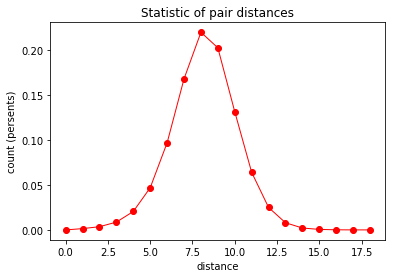

In [19]:
n = 1000
p = 0.007
low = 1
high = 5

G, density = utils.generate_random_digraph(n, p, low, high)
utils.distance_info(G)

Pool size: 8


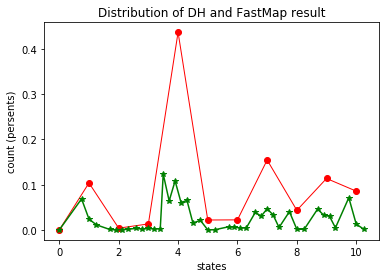

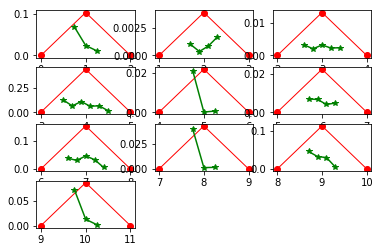

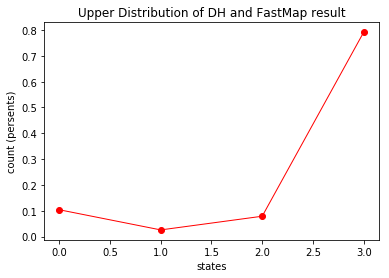

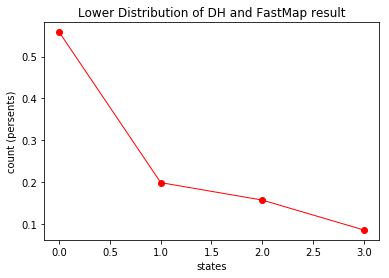

0.22936439546683202


In [20]:
epsilon = 0.01
alg = 'L2'
dis_store = init_dis_store(G)
embedding_aver = difastmap_average(G, 21, epsilon, dis_store, alg)
embedding_max = difastmap_max(G, 19, epsilon, dis_store, alg)
S = int(800)
subset = sample(list(G.nodes()), S)
results = fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg)
print(results)


### Some analysis

1. The improvements of precision is very tiny. (about 3%)
2. Upper tender to be higher than dismax (from abover image 3)
3. Lower tender to be lower than disaver (from abover image 4)

The inner situation of every states: analysis from abover image 1 and 2

Here the considerations are:

- The distribution of those states
- Inside every state, which point is clostest to the real distance?

Blew are the summary on random graph:

1. **10% upper < dismin**: Upper $$dis_{real} \to lower$$
2. 0.25% lower < dismin < upper < disaver: Dismin $$dis_{real} \to upper$$ 
3. 1% lower < dismin < disaver < upper < dismax:  Median $$dis_{real}$$ 
4. **46% lower < dismin < dismax < upper**: Disaver $$dis_{real}$$
5. 2.5% dismin < lower < upper < disaver: Lower $$dis_{real} \to lower$$
6. 2.5% dismin < lower < disaver < upper < dismax: Disaver $$dis_{real}$$
7. **16% dismin < lower < disaver < dismax < upper**: Dismax $$dis_{real} \to median$$
8. 4% disaver < lower < upper < dismax: Upper $$dis_{real} \to lower$$
9. **12% disaver < lower < dismax < upper**: Dismax $$dis_{real} \to lower$$
10. 8% dismax < lower: Lower $$dis_{real} \to lower$$

**Later plan**

1. Try to analysis different graphs, especially the real map.
2. Then try to figure out the relationship between structure of network and the performance of FastMap.
3. Try to think about the idea of embedding general graph problem into the Euclidean space.